In [90]:
%config IPCompleter.greedy=True
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [2]:
def json_read(filename):
    with open(filename, 'r') as inf:
        res = json.load(inf)
    return res

def json_dump(obj, filename, ea=False, indent=4):
    with open(filename, 'w') as ouf:
        json.dump(obj, ouf, ensure_ascii=ea, indent=indent)

### Load data

In [3]:
# word_pairs = json_read('word_pairs.json')
train_wp = json_read('train_dataset_clear.json')
test_wp = json_read('test_dataset_clear.json')

In [4]:
train_wp

[['eff', 'fuck', '+'],
 ['arse', 'butt', '+'],
 ['induce', 'make', '+'],
 ['nates', 'tush', '+'],
 ['one-sided', 'unilateral', '+'],
 ['fittingly', 'properly', '+'],
 ['familiarity', 'liberty', '+'],
 ['repellant', 'repellent', '+'],
 ['illogicality', 'inconsequence', '+'],
 ['marshal', 'mobilise', '+'],
 ['alike', 'like', '+'],
 ['perinatal', 'prenatal', '-'],
 ['neuter', 'sexless', '+'],
 ['filch', 'purloin', '+'],
 ['bear', 'have', '+'],
 ['valuable', 'worthless', '-'],
 ['fore', 'prow', '+'],
 ['distasteful', 'skanky', '+'],
 ['gloominess', 'sadness', '+'],
 ['nomadic', 'wandering', '+'],
 ['get', 'make', '+'],
 ['bob', 'dock', '+'],
 ['fancy', 'fondness', '+'],
 ['orotund', 'tumid', '+'],
 ['big', 'gravid', '+'],
 ['wear', 'weary', '+'],
 ['slow', 'tardily', '+'],
 ['up', 'upward', '+'],
 ['developed', 'highly-developed', '+'],
 ['inconsequence', 'logicality', '-'],
 ['slack', 'slacken', '+'],
 ['sick', 'unhinged', '+'],
 ['fat', 'juicy', '+'],
 ['convalesce', 'deteriorate', '-'],

In [5]:
vocabulary = set()
for w1, w2, _ in train_wp + test_wp:
    vocabulary.add(w1)
    vocabulary.add(w2)

In [150]:
len(vocabulary)

2334

### Fasttext

In [6]:
embeddings = {}

In [8]:
cnt = 0
with open('crawl-300d-2M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore') as inf:
    next(inf)
    for line in tqdm(inf):
        tokens = line.rstrip().split()
        word = tokens[0]
        if word in vocabulary:
            embeddings[word] = list(map(float, tokens[1:]))

# def load_vectors(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data

FileNotFoundError: [Errno 2] No such file or directory: 'crawl-300d-2M.vec'

In [7]:
embeddings = json_read('crawl_emb.json')

In [10]:
existing_word_pairs = []
for w1, w2, label in word_pairs:
    if w1 in embeddings and w2 in embeddings:
        existing_word_pairs.append([w1, w2, label])

In [8]:
def get_svm_data(word_pairs, embeddings):
    inputs = []
    labels = []
    for w1, w2, label in word_pairs:
        if w1 in embeddings and w2 in embeddings:
            e1 = np.array(embeddings[w1])
            e2 = np.array(embeddings[w2])
            inputs.append(np.square(e1 - e2))
            labels.append(label)
    inputs = np.vstack(inputs)
    labels = np.array(labels)
    return inputs, labels

In [12]:
class NetDataloader:
    def __init__(self, word_pairs, embeddings):
        self.inputs = []
        for w1, w2, label in word_pairs:
            if w1 in embeddings and w2 in embeddings:
                e1 = np.array([embeddings[w1]])
                e2 = np.array([embeddings[w2]])
                lb = 1 if label == '+' else -1
                self.inputs.append((e1, e2, lb))
                
    def __iter__(self):
        for input1, input2, label in self.inputs:
            input1 = from_numpy(input1).float()
            input2 = from_numpy(input2).float()
            label = Tensor([label])
            yield input1, input2, label
            
    def __len__(self):
        return len(self.inputs)

In [139]:
# class WeightedNetDataloader(torch.utils.data.IterableDataset):
class WeightedNetDataloader:
    def __init__(self, word_pairs, embeddings):
        self.size = 0
        self.class_data = {}
        for w1, w2, label in word_pairs:
            if w1 in embeddings and w2 in embeddings:
                e1 = np.array([embeddings[w1]])
                e2 = np.array([embeddings[w2]])
#                 e1 = np.array(embeddings[w1])
#                 e2 = np.array(embeddings[w2])
                lb = 1 if label == '+' else -1
                if lb not in self.class_data:
                    self.class_data[lb] = []
                self.class_data[lb].append((e1, e2, lb))
                self.size += 1
        self.labels_dict = [label for i, label in enumerate(self.class_data)]
        self.weights = [self.size / len(self.class_data[self.labels_dict[i]]) for i in range(len(self.labels_dict))]
        weights_sum = sum(self.weights)
        self.weights = [x / weights_sum for x in self.weights]
                
    def __iter__(self):
        for i in range(self.size):
            label = np.random.choice(self.labels_dict, p=self.weights)
            e1, e2, lb = self.class_data[label][np.random.choice(len(self.class_data[label]))]
            input1 = from_numpy(e1).float()
            input2 = from_numpy(e2).float()
            label = Tensor([lb])
            yield input1, input2, label
            
    def __len__(self):
        return self.size

In [11]:
inputs_tr, labels_tr = get_svm_data(train_wp, embeddings)
inputs_te, labels_te = get_svm_data(test_wp, embeddings)

In [87]:
print(np.sum(labels_tr == '+') / np.sum(labels_tr == '-'))
print(np.sum(labels_te == '+') / np.sum(labels_te == '-'))

4.222807017543859
3.5265486725663715
1023


In [153]:
print(np.sum(labels_tr == '+'))
print(np.sum(labels_te == '+'))
print(np.sum(labels_tr == '-'))
print(np.sum(labels_te == '-'))

2407
797
570
226


### SVM

In [76]:
classifier = SVC(kernel='linear', class_weight={'+': 1.0, '-': 3.6})
# classifier = SGDClassifier(alpha=1e-4, class_weight={'+': 1.0, '-': 2.5})

In [77]:
classifier.fit(inputs, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight={'+': 1.0, '-': 2.5},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
pred = classifier.predict(inputs)

In [79]:
results = defaultdict(int)
for i in range(len(pred)):
    res = labels[i] + pred[i]
    results[res] += 1
print(f'synonims: {results["++"] / (results["+-"] + results["++"])}')
print(f'antonims: {results["--"] / (results["--"] + results["-+"])}')

synonims: 0.7568406205923837
antonims: 0.798974358974359


In [41]:
def eveluate_svm(inputs_tr, labels_tr, inputs_te, labels_te):
    classifier = SVC(kernel='linear', class_weight={'+': 1.0, '-': 1.})
    classifier.fit(inputs_tr, labels_tr)
    pred = classifier.predict(inputs_te)
    results = defaultdict(int)
    for i in range(len(pred)):
        res = labels_te[i] + pred[i]
        results[res] += 1
    print(f'synonims: {results["++"] / (results["+-"] + results["++"])}')
    print(f'antonims: {results["--"] / (results["--"] + results["-+"])}')
          
eveluate_svm(inputs_tr, labels_tr, inputs_te, labels_te)

synonims: 0.9372647427854455
antonims: 0.18584070796460178


In [ ]:
# SVC
# 42, 97 - веса 0.1, 1.0
# 76, 80 - веса 1, 3.6
# SGD
# 87, 61 - веса 1, 3.6

### PyTorch

In [30]:
import torch
import torch.nn as nn
from torch import Tensor, optim, from_numpy 

In [31]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        label = label.numpy()[0]
        if label < 0:
            label = 0.0
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [77]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(300, 50),
        )

#         self.fc = nn.Sequential(
#             nn.Linear(300, 200),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(p=0.5),

#             nn.Linear(200, 100),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(p=0.2),

#             nn.Linear(100, 50)
#         )
    
    def forward_once(self, x):
        output = self.fc(x)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [140]:
net = SiameseNetwork()
criterion = nn.CosineEmbeddingLoss(margin=-2.0, reduction='none')
# criterion = ContrastiveLoss(margin=10.0)
# optimizer = optim.RMSprop(net.parameters(), momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
dataloader = WeightedNetDataloader(train_wp, embeddings)
# dataloader = torch.utils.data.DataLoader(WeightedNetDataloader(train_wp, embeddings), batch_size=10)

In [143]:
def train(n_epochs=20):
    net.train()
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for i, data in enumerate(dataloader):
            input1, input2, label = data
#             optimizer.zero_grad()
            output1, output2 = net(input1, input2)
            loss = criterion(output1, output2, label)
#             print(input1.numpy().shape, label.numpy().shape, output1.detach().numpy().shape, loss.detach().numpy().shape)
            ###
#             print(label.numpy()[0])
#             out1 = output1.detach().numpy()
#             out2 = output2.detach().numpy()
#             print(cosine_similarity(out1, out2)[0][0])
#             print(loss.item())
            ###
            loss.backward()
            if i % 10 == 0:
                optimizer.step()
                optimizer.zero_grad()
            epoch_loss += loss.item()
        epoch_loss /= len(dataloader)
        print(f'Epoch {epoch}\n Current loss {epoch_loss:.4f}')
        epoch_loss = 0.0

In [144]:
train()

Epoch 0
 Current loss 1.0776
Epoch 1
 Current loss 1.0642
Epoch 2
 Current loss 1.0326
Epoch 3
 Current loss 1.0130
Epoch 4
 Current loss 1.0085
Epoch 5
 Current loss 0.9968
Epoch 6
 Current loss 0.9773
Epoch 7
 Current loss 0.9718
Epoch 8
 Current loss 0.9757
Epoch 9
 Current loss 0.9743
Epoch 10
 Current loss 0.9623
Epoch 11
 Current loss 0.9528
Epoch 12
 Current loss 0.9592
Epoch 13
 Current loss 0.9449
Epoch 14
 Current loss 0.9590
Epoch 15
 Current loss 0.9534
Epoch 16
 Current loss 0.9297
Epoch 17
 Current loss 0.9426
Epoch 18
 Current loss 0.9588
Epoch 19
 Current loss 0.9437


In [145]:
net.eval()

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=50, bias=True)
  )
)

In [146]:
results = defaultdict(int)
te_dataloader = WeightedNetDataloader(test_wp, embeddings)
for i, data in enumerate(te_dataloader):
    input1, input2, label = data
    out1, out2 = net(input1, input2)
    out1 = out1.detach().numpy()
    out2 = out2.detach().numpy()
    label = '+' if label.numpy()[0] == 1. else '-'
    if cosine_similarity(out1, out2)[0][0] > 0:
#         if label == '-':
#             print(existing_word_pairs[i], cosine_similarity(out1, out2)[0][0])
        label += '+'
    else:
#         if label == '-':
#             print(existing_word_pairs[i], cosine_similarity(out1, out2)[0][0])
        label += '-'
    results[label] += 1
    
print(f'synonims: {results["++"] / (results["+-"] + results["++"])}')
print(f'antonims: {results["--"] / (results["--"] + results["-+"])}')

synonims: 0.7853658536585366
antonims: 0.6344743276283619


In [147]:
def get_svm_data_from_processed(net, dataloader):
    inputs = []
    labels = []
    for i, data in enumerate(dataloader):
        input1, input2, label = data
        out1, out2 = net(input1, input2)
        out1 = out1.detach().numpy()[0]
        out1 /= np.linalg.norm(out1)
        out2 = out2.detach().numpy()[0]
        out2 /= np.linalg.norm(out2)
        label = '+' if label.numpy()[0] == 1. else '-'
        inputs.append(np.square(out1 - out2))
        labels.append(label)
    inputs = np.vstack(inputs)
    labels = np.array(labels)
    return inputs, labels

In [148]:
inputs_tr_net, labels_tr_net = get_svm_data_from_processed(net, dataloader)
inputs_te_net, labels_te_net = get_svm_data_from_processed(net, te_dataloader)

In [149]:
eveluate_svm(inputs_tr_net, labels_tr_net, inputs_te_net, labels_te_net)

synonims: 0.7545454545454545
antonims: 0.6737235367372354


In [ ]:
# CosineEmbeddingLoss, Adam, WeightedDataLoader, 
# synonims: 0.7077625570776256
# antonims: 0.6703980099502488

# Почему ничего не вышло

In [88]:
def dist_between_vectors(word_pairs, embeddings, label):
    dist = []
    for w1, w2, l in word_pairs:
        if l == label:
            if w1 in embeddings and w2 in embeddings:
                e1 = np.array(embeddings[w1])
                e2 = np.array(embeddings[w2])
                dist.append(np.linalg.norm(e1 - e2))
    return dist

dist_a = dist_between_vectors(train_wp, embeddings, '-')
dist_s = dist_between_vectors(train_wp, embeddings, '+')

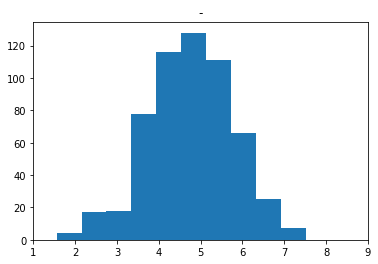

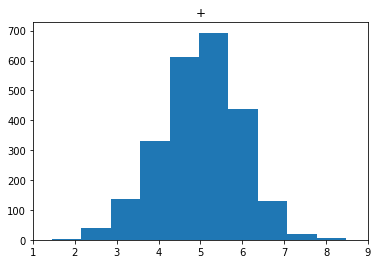

In [103]:
def plot_hist(dist, label, xlim):
    plt.xlim((1, 9))
    plt.hist(dist)
    plt.title(label)
    plt.show()

plot_hist(dist_a, '-', (1, 9))
plot_hist(dist_s, '+', (1, 9))